<a href="https://colab.research.google.com/github/zzeng507/sec-financial-analysis/blob/main/sec_financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Hello SEC Financial Analysis")


Hello SEC Financial Analysis


In [16]:
# =========================
# SEC Financial Analysis | End-to-end notebook
# =========================

# 0) Setup & deps
!pip -q install yfinance

import re, time, requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# ---- fill with your real name & email (required by SEC) ----
YOUR_NAME  = "YOUR_NAME"
YOUR_EMAIL = "YOUR_EMAIL@example.com"

SEC_HEADERS = {
    "User-Agent": f"{YOUR_NAME} {YOUR_EMAIL}",
    "Accept-Encoding": "gzip, deflate",
    "Accept": "application/json",
    "Host": "data.sec.gov"
}



In [26]:
# -------- Choose peers (Tesla, Nvidia, Ford) --------
TICKERS = ["TSLA", "NVDA", "F"]
YEARS_WINDOW = 5

# Fallback CIKs for our chosen tickers
FALLBACK_CIKS = {
    "TSLA": "0001318605",
    "NVDA": "0001045810",
    "F":    "0000037996",
    "WMT":  "0000104169",
    "COST": "0000909832",
    "TGT":  "0000027419"
}

# Build dict of tickers → CIK
CIKS = {t: FALLBACK_CIKS[t] for t in TICKERS}


plt.rcParams["figure.figsize"] = (8,4)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

ANNUAL_FORMS = {"10-K","10-K/A","20-F","20-F/A"}
EXCLUDE_PATTERNS = [
    r"DeferredRevenue", r"ContractWithCustomer", r"RevenueRecognized",
    r"IncreaseDecreaseInDeferredRevenue", r"ProFormaRevenue",
    r"Geographic.*Revenue", r"Regulated.*Revenue"
]
_exclude_re = re.compile("|".join(EXCLUDE_PATTERNS), re.I)
BASE_FACTS = "https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"

In [27]:
def fetch_companyfacts(cik: str) -> dict:
    time.sleep(0.25)  # be polite
    r = requests.get(BASE_FACTS.format(cik=cik), headers=SEC_HEADERS, timeout=60)
    r.raise_for_status()
    return r.json()

def infer_year(rec: dict):
    if rec.get("fy"):
        return int(rec["fy"])
    frame = rec.get("frame") or ""
    m = re.search(r"(?:FY|CY)?(\d{4})", frame)
    if m: return int(m.group(1))
    end = rec.get("end") or ""
    if len(end) >= 4 and end[:4].isdigit(): return int(end[:4])
    return None

def pick_records(records):
    items=[]
    for r in records:
        fy = infer_year(r)
        if fy and (r.get("val") is not None):
            rr = dict(r); rr["fy"] = fy
            items.append(rr)
    if not items: return []
    best={}
    for r in items:
        fy = int(r["fy"]); form=r.get("form"); end=r.get("end") or ""
        score = (1 if form in ANNUAL_FORMS else 0, end)
        if (fy not in best) or (score > best[fy]["_score"]):
            best[fy] = {"fy":fy,"val":float(r["val"]), "form":form, "end":end, "_score":score}
    return sorted([{"fy":v["fy"],"val":v["val"],"form":v["form"],"end":v["end"]} for v in best.values()],
                  key=lambda x:x["fy"])

In [28]:
def extract_units_generic(units_dict):
    if "USD" in units_dict: return pick_records(units_dict["USD"])
    for _, v in units_dict.items():
        if isinstance(v, list): return pick_records(v)
    return None

def autodetect_revenue_key(facts: dict):
    """Pick the 'Revenue/Sales' key with most annual points; exclude deferred/recognized variants."""
    best_key, best_recs = None, []
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    for key, detail in usgaap.items():
        name = str(key)
        if (("Revenue" in name) or ("Sales" in name)) and (not _exclude_re.search(name)):
            units = detail.get("units", {})
            recs = extract_units_generic(units) or []
            if len(recs) > len(best_recs):
                best_recs, best_key = recs, name
    return best_key, best_recs

CORE_KEYS = {
    "NetIncome":          ("us-gaap","NetIncomeLoss"),
    "Assets":             ("us-gaap","Assets"),
    "Liabilities":        ("us-gaap","Liabilities"),
    "Equity":             ("us-gaap","StockholdersEquity"),
    "CurrentAssets":      ("us-gaap","AssetsCurrent"),
    "CurrentLiabilities": ("us-gaap","LiabilitiesCurrent"),
    "GrossProfit":        ("us-gaap","GrossProfit"),
}

In [29]:
def get_financials_autorev(ticker: str, cik: str):
    facts = fetch_companyfacts(cik)
    rows={}
    # Auto-detect revenue
    rev_key, rev_recs = autodetect_revenue_key(facts)
    if rev_recs:
        for r in rev_recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy]["Revenue"] = val
    # Core metrics
    for m,(ns2,k2) in CORE_KEYS.items():
        detail = facts.get("facts",{}).get(ns2,{}).get(k2)
        if not detail: continue
        recs = extract_units_generic(detail.get("units", {})) or []
        for r in recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy][m] = val
    df = pd.DataFrame(list(rows.values())).sort_values("Year") if rows else pd.DataFrame()
    return df, rev_key

def compute_ratios(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(); eps = 1e-9
    df["ROE"] = df["NetIncome"] / (df["Equity"] + eps)
    df["ROA"] = df["NetIncome"] / (df["Assets"] + eps)
    df["GrossMargin"] = df.get("GrossProfit", np.nan) / (df.get("Revenue", np.nan) + eps)
    df["DebtToEquity"] = df["Liabilities"] / (df["Equity"] + eps)
    df["CurrentRatio"] = df["CurrentAssets"] / (df["CurrentLiabilities"] + eps)
    df["RevenueGrowth"] = df.groupby("Ticker")["Revenue"].pct_change()
    df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()
    return df

In [30]:
def plot_metric(df, metric, ylabel=None, title=None):
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        plt.plot(sub["Year"], sub[metric], marker="o", label=t)
    plt.legend(); plt.xlabel("Year"); plt.ylabel(ylabel or metric)
    if title: plt.title(title)
    plt.grid(True); plt.show()
def bullet_summary(df: pd.DataFrame) -> str:
    lines=[]
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        y0,y1 = sub["Year"].min(), sub["Year"].max()
        rev0,rev1 = sub.iloc[0].get("Revenue", np.nan), sub.iloc[-1].get("Revenue", np.nan)
        ni0,ni1  = sub.iloc[0].get("NetIncome", np.nan), sub.iloc[-1].get("NetIncome", np.nan)
        roe_avg  = sub["ROE"].mean()
        dte_last = sub.iloc[-1].get("DebtToEquity", np.nan)
        lines.append(f"- **{t}** ({y0}→{y1}): Revenue {rev0:,.0f} → {rev1:,.0f}; "
                     f"Net Income {ni0:,.0f} → {ni1:,.0f}; Avg ROE {roe_avg:.2%}; Latest D/E {dte_last:.2f}.")
    return "\n".join(lines)

Auto-detected Revenue key per ticker: {'TSLA': 'CostOfRevenue', 'NVDA': 'CostOfRevenue', 'F': 'Revenues'}


,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit
0,F,2022,"158,057,000,000.00",NaN,"255,884,000,000.00","212,717,000,000.00","43,242,000,000.00","116,476,000,000.00","96,866,000,000.00",NaN
1,F,2023,"176,191,000,000.00","4,347,000,000.00","273,310,000,000.00","230,512,000,000.00","42,773,000,000.00","121,481,000,000.00","101,531,000,000.00",NaN
2,F,2024,"184,992,000,000.00","5,879,000,000.00","285,196,000,000.00","240,338,000,000.00","44,835,000,000.00","124,474,000,000.00","106,859,000,000.00",NaN
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN
4,NVDA,2022,"9,439,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00"
5,NVDA,2023,"11,618,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00"
6,NVDA,2024,"16,621,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00"
7,NVDA,2025,"32,639,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00"
8,NVDA,2026,"30,284,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00"
9,TSLA,2022,"60,609,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00"


/tmp/ipython-input-4071191822.py:30: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["RevenueGrowth"] = df.groupby("Ticker")["Revenue"].pct_change()
/tmp/ipython-input-4071191822.py:31: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()


,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit,ROE,ROA,GrossMargin,DebtToEquity,CurrentRatio,RevenueGrowth,NetIncomeGrowth
0,F,2022,"158,057,000,000.00",NaN,"255,884,000,000.00","212,717,000,000.00","43,242,000,000.00","116,476,000,000.00","96,866,000,000.00",NaN,NaN,NaN,NaN,4.92,1.20,NaN,NaN
1,F,2023,"176,191,000,000.00","4,347,000,000.00","273,310,000,000.00","230,512,000,000.00","42,773,000,000.00","121,481,000,000.00","101,531,000,000.00",NaN,0.10,0.02,NaN,5.39,1.20,0.11,NaN
2,F,2024,"184,992,000,000.00","5,879,000,000.00","285,196,000,000.00","240,338,000,000.00","44,835,000,000.00","124,474,000,000.00","106,859,000,000.00",NaN,0.13,0.02,NaN,5.36,1.16,0.05,0.35
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN,-0.00,-0.00,NaN,5.50,1.10,0.00,-1.01
4,NVDA,2022,"9,439,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00",0.37,0.22,1.85,0.66,6.65,NaN,NaN
5,NVDA,2023,"11,618,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00",0.20,0.11,1.32,0.86,3.52,0.23,-0.55
6,NVDA,2024,"16,621,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00",0.69,0.45,2.67,0.53,4.17,0.43,5.81
7,NVDA,2025,"32,639,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00",0.92,0.65,3.00,0.41,4.44,0.96,1.45
8,NVDA,2026,"30,284,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00",0.45,0.32,2.00,0.41,4.21,-0.07,-0.38
9,TSLA,2022,"60,609,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00",0.28,0.15,0.34,0.82,1.53,NaN,NaN


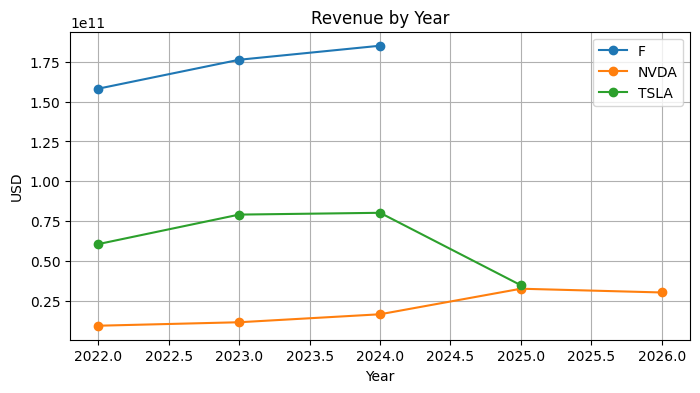

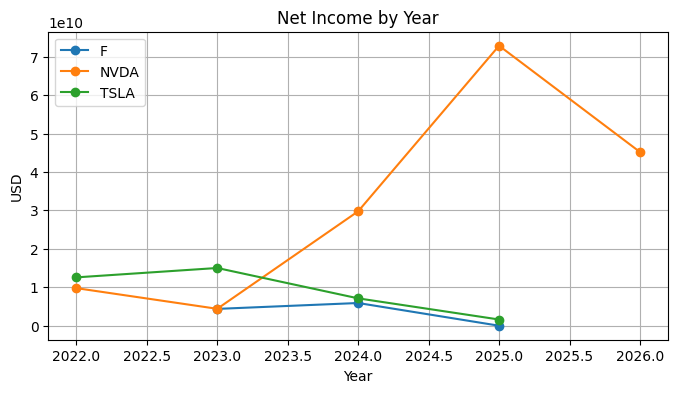

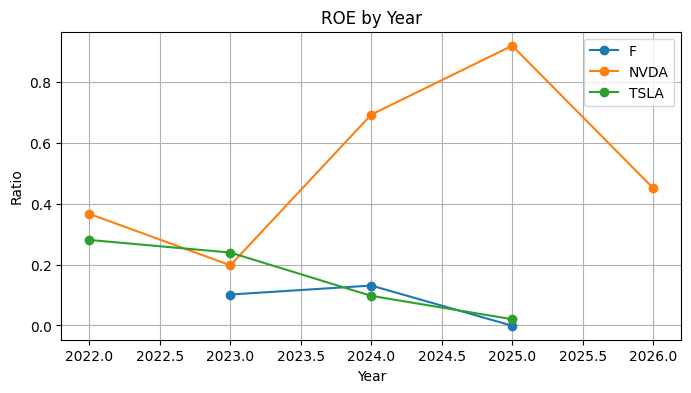

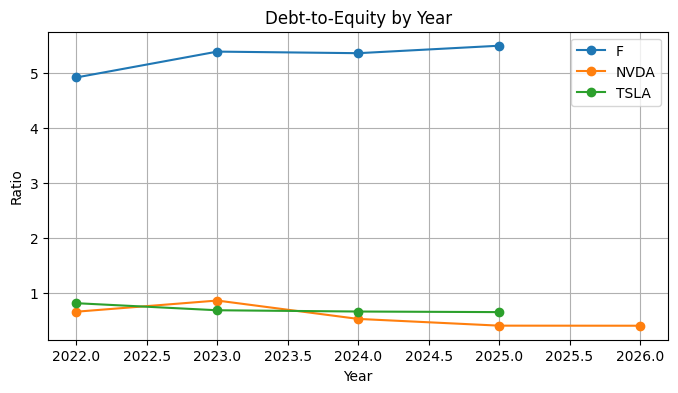

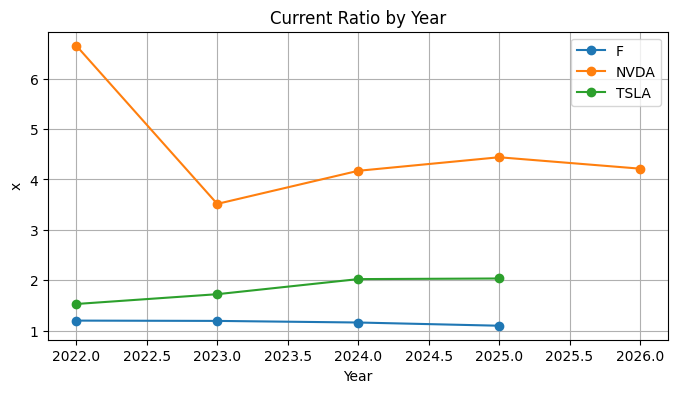

Saved: /content/sec_financials_clean.csv

Key takeaways:

- **F** (2022→2025): Revenue 158,057,000,000 → nan; Net Income nan → -36,000,000; Avg ROE 7.73%; Latest D/E 5.50.
- **NVDA** (2022→2026): Revenue 9,439,000,000 → 30,284,000,000; Net Income 9,752,000,000 → 45,197,000,000; Avg ROE 52.53%; Latest D/E 0.41.
- **TSLA** (2022→2025): Revenue 60,609,000,000 → 34,800,000,000; Net Income 12,556,000,000 → 1,581,000,000; Avg ROE 15.95%; Latest D/E 0.65.


In [32]:
# Build dataframe using auto-detected revenue key
frames, chosen = [], {}
for t in TICKERS:
    df_t, rev_key = get_financials_autorev(t, CIKS[t])
    df_t["Ticker"] = t
    frames.append(df_t)
    chosen[t] = rev_key

raw_df = pd.concat(frames, ignore_index=True)
max_year = int(raw_df["Year"].max())
keep_years = list(range(max_year - YEARS_WINDOW + 1, max_year + 1))
raw_df = raw_df[raw_df["Year"].isin(keep_years)].sort_values(["Ticker","Year"]).reset_index(drop=True)

print("Auto-detected Revenue key per ticker:", chosen)
display(raw_df.head(12))

# Ratios
metrics_df = compute_ratios(raw_df)
display(metrics_df.head(12))

# Plots
plot_metric(metrics_df, "Revenue", "USD", "Revenue by Year")
plot_metric(metrics_df, "NetIncome", "USD", "Net Income by Year")
plot_metric(metrics_df, "ROE", "Ratio", "ROE by Year")
plot_metric(metrics_df, "DebtToEquity", "Ratio", "Debt-to-Equity by Year")
plot_metric(metrics_df, "CurrentRatio", "x", "Current Ratio by Year")

# Export CSV
out_csv = "/content/sec_financials_clean.csv"
metrics_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

print("\nKey takeaways:\n")
print(bullet_summary(metrics_df))

